<a href="https://colab.research.google.com/github/SaadIqbalGH/Deep-Learning-CNN-Transfer-Learning-DCGAN/blob/main/Skin_Cancer_ResNet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_directory  = '/content/drive/MyDrive/Colab Notebooks'

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HAM10000_metadata.csv')
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
8904,HAM_0006174,ISIC_0032233,nv,histo,75.0,male,back,rosendahl
5351,HAM_0004228,ISIC_0027748,nv,follow_up,65.0,male,lower extremity,vidir_molemax
3977,HAM_0003329,ISIC_0031581,nv,follow_up,40.0,female,trunk,vidir_molemax
8650,HAM_0000777,ISIC_0028364,nv,histo,50.0,female,back,rosendahl
6372,HAM_0006966,ISIC_0028614,nv,follow_up,30.0,female,trunk,vidir_molemax


In [5]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [77]:
len(imageid_path_dict)

10015

In [7]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [8]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...


In [9]:
%%time
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

CPU times: user 2min 2s, sys: 5.4 s, total: 2min 8s
Wall time: 41min 38s


In [12]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[191, 152, 194], [191, 153, 195], [192, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[186, 129, 140], [192, 136, 151], [198, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[139, 95, 118], [158, 114, 138], [178, 133, ..."


# Exploratory Data Analysis

In [13]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index, 
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index, 
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

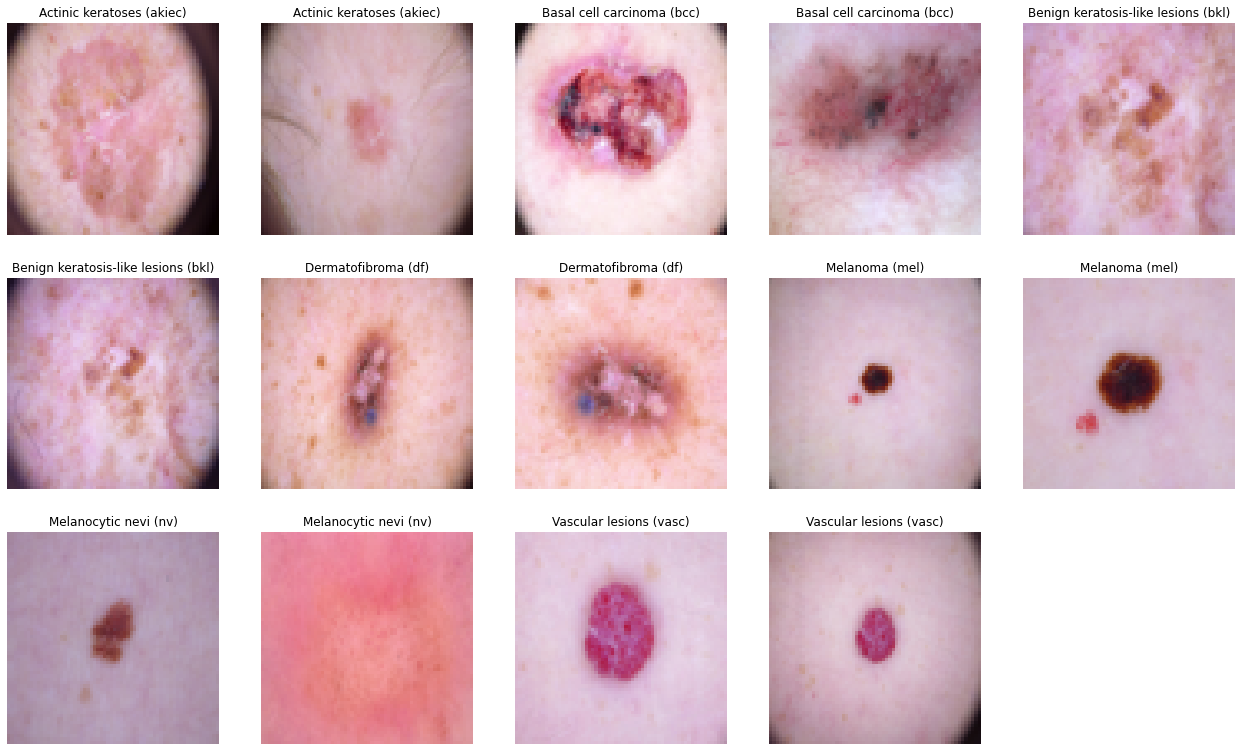

In [14]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [10, 8]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
 8   cell_type     10015 non-null  object 
 9   path          10015 non-null  object 
 10  image_pixel   10015 non-null  object 
dtypes: float64(1), object(10)
memory usage: 860.8+ KB


# Preprocessing

In [16]:
# Checking null values
data.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
cell_type        0
path             0
image_pixel      0
dtype: int64

In [17]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [18]:
# Categorically encoding label of the images 
data['label'] = data['dx'].map(reverse_label_mapping.get)

In [26]:
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,cell_type,path,image_pixel,label
259,HAM_0001309,ISIC_0033629,bkl,histo,60,female,lower extremity,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[224, 200, 223], [223, 196, 222], [232, 211,...",2
7384,HAM_0006883,ISIC_0032619,nv,histo,40,female,face,vidir_modern,Melanocytic nevi (nv),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[119, 95, 98], [128, 102, 108], [136, 108, 1...",0
1490,HAM_0003083,ISIC_0033428,mel,histo,75,male,chest,vidir_modern,Melanoma (mel),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[2, 2, 1], [4, 4, 4], [6, 5, 7], [14, 12, 15...",1
165,HAM_0001385,ISIC_0033212,bkl,histo,50,female,neck,vidir_modern,Benign keratosis-like lesions (bkl),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[153, 133, 125], [157, 136, 128], [160, 138,...",2
8168,HAM_0005902,ISIC_0027285,nv,histo,40,female,foot,vienna_dias,Melanocytic nevi (nv),/content/drive/MyDrive/Colab Notebooks/HAM1000...,"[[[202, 160, 141], [199, 158, 138], [200, 158,...",0


# OverSampling for Handling Class Imbalance

In [33]:
data = data.sort_values('label')
data = data.reset_index()

In [34]:
%%time
# excluding 'nv' category at label = 0
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = df_index1.append([df_index1]*4, ignore_index = True)
df_index2 = df_index2.append([df_index2]*4, ignore_index = True)
df_index3 = df_index3.append([df_index3]*11, ignore_index = True)
df_index4 = df_index4.append([df_index4]*17, ignore_index = True)
df_index5 = df_index5.append([df_index5]*45, ignore_index = True)
df_index6 = df_index6.append([df_index6]*52, ignore_index = True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

CPU times: user 127 ms, sys: 4.02 ms, total: 131 ms
Wall time: 131 ms


In [35]:
%%time
print(data.shape)
print(final_data.shape)

(10015, 14)
(45756, 14)
CPU times: user 111 µs, sys: 4 µs, total: 115 µs
Wall time: 121 µs


In [36]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index, 
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index, 
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get), 
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

In [37]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 64, 64, 3)
(10015, 1)


In [38]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 64, 64, 3)
(45756, 1)


# Image Augmentation and Train, Test Split 

In [39]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [40]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [41]:
X_train_aug.shape, Y_train_aug.shape

((36604, 64, 64, 3), (36604, 1))

In [42]:
X_test_aug.shape, Y_test_aug.shape

((9152, 64, 64, 3), (9152, 1))

# Functions for Model Creation - ResNet152

In [48]:
from keras.applications.resnet import ResNet152
conv_model = ResNet152(weights='imagenet', include_top=False, input_shape=(64,64,3))

from keras.layers import BatchNormalization
from keras import regularizers
from keras.regularizers import l2

def create_model_ResNet152():
    for layer in conv_model.layers:
        layer.trainable = False
        
    x = layers.Flatten()(conv_model.output)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x= (BatchNormalization(momentum=0.99, epsilon=0.01))(x)
    x = (Dropout(0.2))(x)
    
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x= (BatchNormalization(momentum=0.99, epsilon=0.01))(x)
    x = (Dropout(0.2))(x)   
    
    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x= (BatchNormalization(momentum=0.99, epsilon=0.01))(x)
    x = (Dropout(0.2))(x)   
  
    predictions = layers.Dense(7, activation='softmax')(x)
    
    model = Model(inputs=conv_model.input, outputs=predictions)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])  
    model.summary()
    
    return model
    
    

# Train Model

In [49]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto', restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history
    
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()
    

# Test Model

In [50]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

In [51]:
model1 = create_model_ResNet152()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 59,431,111
Trainable params: 1,059,719
Non-trainable params: 58,371,392
__________________________________________________________________________________________________


In [52]:
model1_history = train_model(model1, X_train_aug, Y_train_aug, 50)

Epoch 1/50
458/458 [==============================] - 102s 200ms/step - loss: 0.7671 - accuracy: 0.7321 - val_loss: 0.3801 - val_accuracy: 0.8577
Epoch 2/50
458/458 [==============================] - 92s 200ms/step - loss: 0.2586 - accuracy: 0.9098 - val_loss: 0.2470 - val_accuracy: 0.9141
Epoch 3/50
458/458 [==============================] - 92s 200ms/step - loss: 0.1737 - accuracy: 0.9398 - val_loss: 0.2671 - val_accuracy: 0.9190
Epoch 4/50
458/458 [==============================] - 88s 193ms/step - loss: 0.0931 - accuracy: 0.9681 - val_loss: 0.1209 - val_accuracy: 0.9639
Epoch 5/50
458/458 [==============================] - 88s 192ms/step - loss: 0.0932 - accuracy: 0.9689 - val_loss: 0.2519 - val_accuracy: 0.9226
Epoch 6/50
458/458 [==============================] - 88s 193ms/step - loss: 0.0866 - accuracy: 0.9701 - val_loss: 0.1316 - val_accuracy: 0.9641
Epoch 7/50
458/458 [==============================] - 88s 192ms/step - loss: 0.0435 - accuracy: 0.9849 - val_loss: 0.1260 - val_a

In [54]:
plot_model_training_curve(model1_history)

Test Accuracy: 97.880%
              precision    recall  f1-score   support

          nv       1.00      0.87      0.93      1385
         mel       0.93      0.99      0.96      1328
         bkl       0.95      1.00      0.97      1294
         bcc       0.99      1.00      0.99      1325
       akiec       0.99      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



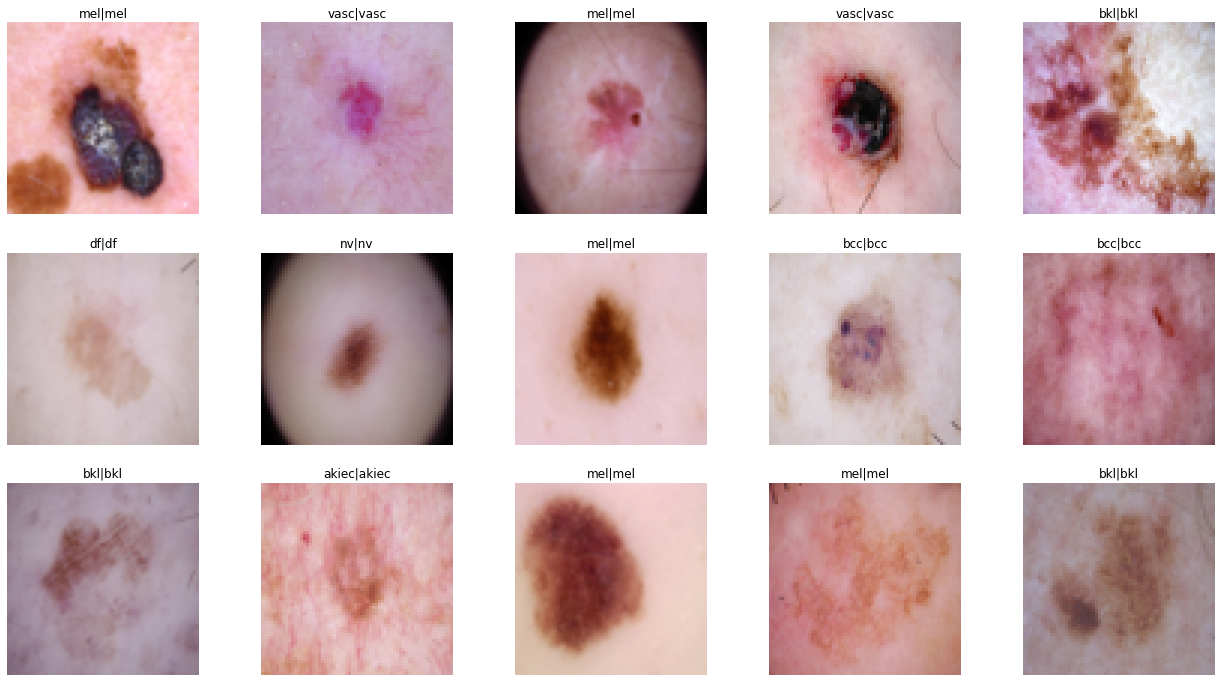

In [55]:
test_model(model1, X_test_aug, Y_test_aug)